# ANALYSIS ON THE VEHICLE 3270_79350

In [46]:
vehicle_code = "3270_79350"
stop = "5"

### IMPORT LIBRARIES

In [47]:
# psycopg2 is a library to execute sql queries in python
import psycopg2
# folium allows to visualize geolocalized data with the jupyter notebook
import folium
from folium.plugins import MarkerCluster
# sys is required to use the open function to write on file
import sys
# pandas is needed to read the csv file and to perform some basic operations on dataframes
import pandas as pd
# matplotlib is used to draw graphs
import matplotlib.pyplot as plt
# numpy is for scinetific computations
import numpy as np
# ST_AsGeoJSON returns a json object, so we can use json.load to parse it
import json
# scatter plot with color density
from scipy.stats import gaussian_kde

**WARNING! RUN ONLY ONCE TO SAVE THE CSV FILES!**

**YOU DON'T NEED TO CONNECT TO THE SERVER ONCE YOU ALREADY HAVE THE FILES**

### CONNECT TO THE DATASET

In [48]:
conn = psycopg2.connect("dbname=irpet", host="146.48.83.137", user="sbolgi", password="sbolgi2019", port="5435")

# the cursor allows Python code to execute PostgreSQL command in a database session.
cur = conn.cursor()

In [49]:
# First query: select all trajectories of vehicle 14710_129450
query1 = "SELECT * FROM tak.vodafone_zel1_traj_"+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [50]:
# Store result in csv file but this time geometry is converted to coordinates

# First query: select all trajectories of vehicle 14710_129450
query1 = """
    SELECT vehicle, tid, ST_AsGeoJSON(traj) as trajcoord, company, vehicletype, length, duration, start_time, end_time
    FROM tak.vodafone_zel1_traj_"""+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [51]:
conn.close()

###### Open csv just created and execute usual statistics

In [52]:
df = pd.read_csv('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv') 

In [53]:
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.")

The dataset has 3201 rows and 9 columns.


In [54]:
df.head(5)

,vehicle,tid,traj,company,vehicletype,length,duration,start_time,end_time
0,3270_79350,1646,01020000A0E610000002000000FF06EDD5C7C33740132C...,9810,Van,0.001076,300.0,2017-12-15 16:48:55,2017-12-15 16:53:55
1,3270_79350,36,01020000A0E610000003000000460A65E1EB873740DBDE...,9810,Van,2.137420,38.0,2017-07-04 11:00:29,2017-07-04 11:01:07
2,3270_79350,1647,01020000A0E6100000030000008FC70C54C6C337402497...,9810,Van,0.000551,137.0,2017-12-15 16:58:55,2017-12-15 17:01:12
3,3270_79350,1781,01020000A0E6100000030000007ADE8D0585BD37408941...,9810,Van,0.000893,8.0,2018-01-10 09:46:11,2018-01-10 09:46:19
4,3270_79350,2160,01020000A0E610000003000000AF25E4839EC137409C87...,9810,Van,0.003449,27.0,2018-03-01 11:49:51,2018-03-01 11:50:18


In [55]:
print("the vehicle is characterized by 8 fields")
print("tid: has ", len(df["tid"].unique()), "unique values")
print("company: has ", len(df["company"].unique()), "unique values: ", df["company"].unique())
print("vehicletype: has ", len(df["vehicletype"].unique()), "unique values")

the vehicle is characterized by 8 fields
tid: has  3201 unique values
company: has  2 unique values:  ['9810' '\ufeff9810']
vehicletype: has  1 unique values


In [56]:
df[["length", "duration"]].describe()

,length,duration
count,3201.000000,3201.000000
mean,7.808355,807.896907
std,15.834212,1000.256867
min,0.000000,1.000000
25%,0.004127,152.000000
50%,0.777751,300.000000
75%,9.377577,1219.000000
max,220.094877,8280.000000


the 90% of the total is  2880.9
the length of the 90% is  24.972083145335194
the duration of the 90% is  2239.0


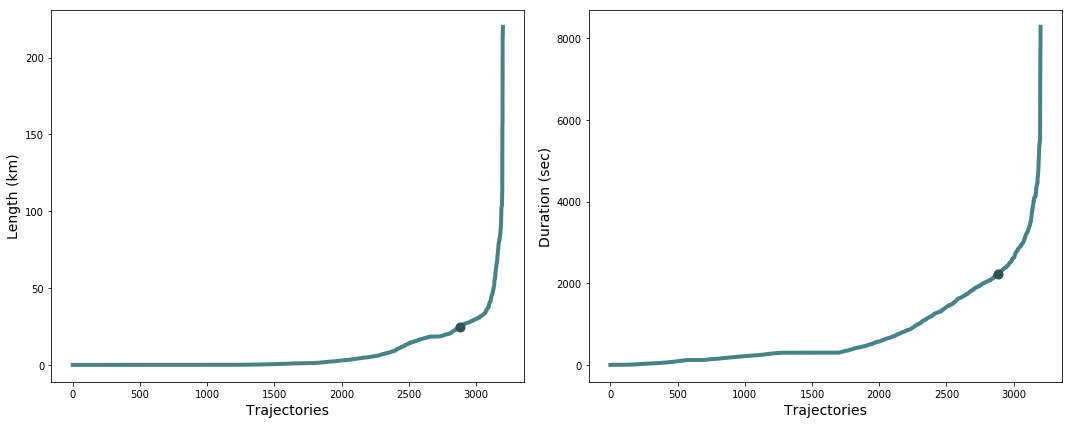

In [57]:
perc90 = (df.shape[0] * 90)/100
print("the 90% of the total is ", perc90)

perc90_i = int(perc90)

print("the length of the 90% is ", sorted(df["length"])[perc90_i])
print("the duration of the 90% is ", sorted(df["duration"])[perc90_i])

fig = plt.figure(figsize=(15, 6)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
ax.plot(range(0,df.shape[0]), sorted(df["length"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["length"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Length (km)", fontsize=14)

ax = plt.subplot2grid(fig_dims, (0, 1))
ax.plot(range(0,df.shape[0]), sorted(df["duration"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["duration"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.tight_layout()

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_distr.png', format='png', bbox_inches='tight')

### let's zoom on the values "in the area", hence for less than 0.2 km

In [58]:
df_mini = df[df["length"] < 0.2]

The number of trajectories that lasted for less than 200 meters is 1342


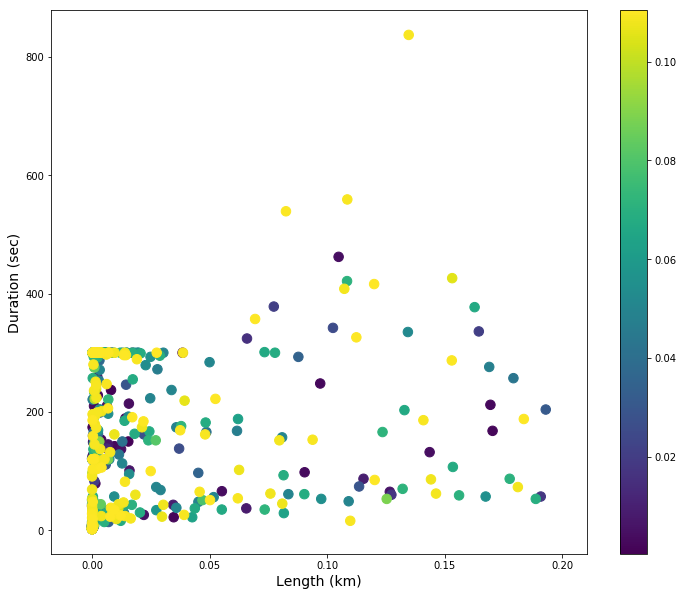

In [59]:
print("The number of trajectories that lasted for less than 200 meters is", df_mini.shape[0])

fig = plt.figure(figsize=(12, 10)) 
fig_dims = (1, 1)

x = df_mini["length"]
y = df_mini["duration"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax = plt.subplot2grid(fig_dims, (0, 0))
density = ax.scatter(x, y, c=z, s=90)
fig.colorbar(density)

plt.xlabel("Length (km)", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_200m.png', format='png', bbox_inches='tight')

### This time we use the csv with the coordinates to try to plot them

In [60]:
df_coord = pd.read_csv('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv') 

In [61]:
def swapXY(traj):
    new_traj = []
    for i in traj:
        new_traj.append([i[1], i[0]])
    return new_traj

In [62]:
coords = []

for el in  df_coord["trajcoord"]:
    y = json.loads(el)
    c = swapXY(y["coordinates"])
    coords.append(c)

In [63]:
df_coord["coord"] = coords

In [64]:
df_coord.head(5)

,vehicle,tid,trajcoord,company,vehicletype,length,duration,start_time,end_time,coord
0,3270_79350,1646,"{""type"":""LineString"",""coordinates"":[[23.764768...",9810,Van,0.001076,300.0,2017-12-15 16:48:55,2017-12-15 16:53:55,"[[37.871045, 23.764768], [37.871043, 23.764756]]"
1,3270_79350,36,"{""type"":""LineString"",""coordinates"":[[23.530943...",9810,Van,2.137420,38.0,2017-07-04 11:00:29,2017-07-04 11:01:07,"[[38.062936, 23.530943], [38.047903, 23.537163..."
2,3270_79350,1647,"{""type"":""LineString"",""coordinates"":[[23.764745...",9810,Van,0.000551,137.0,2017-12-15 16:58:55,2017-12-15 17:01:12,"[[37.87105, 23.764745], [37.871053, 23.76474],..."
3,3270_79350,1781,"{""type"":""LineString"",""coordinates"":[[23.740311...",9810,Van,0.000893,8.0,2018-01-10 09:46:11,2018-01-10 09:46:19,"[[37.943875, 23.740311], [37.943875, 23.740311..."
4,3270_79350,2160,"{""type"":""LineString"",""coordinates"":[[23.756325...",9810,Van,0.003449,27.0,2018-03-01 11:49:51,2018-03-01 11:50:18,"[[38.088336, 23.756325], [38.088305, 23.756323..."


The majority of trajectories are not relevant. We can consider all trajectories beaneath a certain threashold just as GPS errors. In particular we consider just trajectories where the _length_ is at least 0.2 km;

In [65]:
#remove trajectories of less than 200 meters
df_long = df_coord[df_coord["length"] > 0.2]

In [66]:
print ("Of the total", df_coord.shape[0], "just", df_long.shape[0], "are trajectories are significant")

Of the total 3201 just 1859 are trajectories are significant


In [67]:
df_long = df_long.drop(columns=['trajcoord'])

In [68]:
df_long.head(5)

,vehicle,tid,company,vehicletype,length,duration,start_time,end_time,coord
1,3270_79350,36,9810,Van,2.137420,38.0,2017-07-04 11:00:29,2017-07-04 11:01:07,"[[38.062936, 23.530943], [38.047903, 23.537163..."
5,3270_79350,445,9810,Van,13.433879,197.0,2017-07-28 14:16:49,2017-07-28 14:20:06,"[[38.108456, 21.48656], [38.120005, 21.637656]..."
19,3270_79350,2551,9810,Van,0.572790,219.0,2018-04-13 08:13:39,2018-04-13 08:17:18,"[[37.950508, 23.67472], [37.950508, 23.67472],..."
20,3270_79350,1535,9810,Van,0.671722,181.0,2017-12-01 18:14:56,2017-12-01 18:17:57,"[[37.946695, 23.677233], [37.946695, 23.677233..."
21,3270_79350,1821,9810,Van,0.940182,240.0,2018-01-15 14:07:15,2018-01-15 14:11:15,"[[38.071494, 23.531146], [38.071494, 23.531146..."


**The problem is that we can't draw all the trajectories together, it's a computation too heavy**

We can split it for periods of time

In [69]:
print("the first trajectory starts at", min(df_long["start_time"]))
print("the last trajectory finish at", max(df_long["start_time"]))

the first trajectory starts at 2017-07-01 09:54:14
the ast trajectory finish at 2018-06-28 19:15:55


In [70]:
df_long['start_month'] = pd.DatetimeIndex(df_long['start_time']).month

In [71]:
def center_traj(coords):
    sum_x = 0
    sum_y = 0
    for i in coords:
        sum_x += i[0][0]
        sum_y += i[0][1]
    c_x = sum_x / len(coords)
    c_y = sum_y / len(coords)
    return c_x, c_y

**JULY 2017**

In [72]:
df_july = df_long[df_long["start_month"] == 7]

In [73]:
print ("in july this vehicle has", len(df_july), "significant trajectories")

in july this vehicle has 208 significant trajectories


In [74]:
coords = df_july["coord"].tolist()
c_x, c_y = center_traj(coords)

In [75]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8)
for i in range(len(df_july)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_july)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m

**JANUARY 2018**

In [76]:
df_jan = df_long[df_long["start_month"] == 1]

In [77]:
print ("in november this vehicle has", len(df_jan), "significant trajectories")

in november this vehicle has 164 significant trajectories


In [78]:
coords = df_jan["coord"].tolist()
c_x, c_y = center_traj(coords)

In [79]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8.4)
for i in range(len(df_jan)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_jan)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m